# Computer vision course

In this tutorial you'll learn to use a pre trained model to classify objects in images. The input image can be of any size.

by Odd Eirik Igland

## Imports

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, hub
from torchvision import models, transforms

## Define and instanciate the model

The model below is based on the ResNet-18 model. Its customized to use a convolutional layer instead of a fully-connected layer in the end to handle any image input size.

By setting the pretrained variable to true the network weights will be downloaded.

In [2]:
class CustomResNet(models.ResNet):
    def __init__(self, num_classes=1000, pretrained=False, **kwargs):
        super().__init__(
            block=models.resnet.BasicBlock,
            layers=[2, 2, 2, 2],
            num_classes=num_classes,
            **kwargs
        )
        if pretrained:
            state_dict = hub.load_state_dict_from_url(
                models.resnet.model_urls["resnet18"], progress=True
            )
            self.load_state_dict(state_dict)

        # changes the original resnet architecture to not use fc layers
        self.avgpool = nn.AvgPool2d((7, 7))

        self.last_conv = nn.Conv2d(
            in_channels=self.fc.in_features, out_channels=num_classes, kernel_size=1
        )

        # copying weights and bias from the fc layer
        self.last_conv.weight.data.copy_(
            self.fc.weight.data.view(*self.fc.weight.data.shape, 1, 1)
        )
        self.last_conv.bias.data.copy_(self.fc.bias.data)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)

        # Uses conv layer instead of FC, which is used in the original ResNet
        x = self.last_conv(x)
        return x

model = CustomResNet(pretrained=True).eval()

The ResNet network is trained on a data set called imagenet. This is a data set with more than 14 million images. All this images are labeled into 1000 clases. The labels can be found in *imagenet_classes.txt*.

In [ ]:
with open("data/imagenet_classes.txt") as f:
    labels = [line.strip() for line in f.readlines()]
labels[:5]

This pretrained model can take any image as input. Add more images to the *images* folder, and add the filename in the list below to classify its content.

In [4]:
images = ["flamingo.jpg", "boat.jpeg", "camel.jpg", "pelican.jpg"]
IMAGE_NAME = f"images/{images[2]}"

(725, 1920, 3)


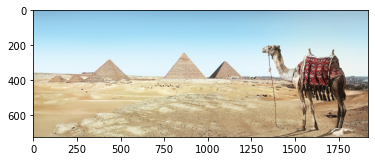

In [26]:
original_image = cv2.imread(IMAGE_NAME)
print(original_image.shape)
rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image);

The image is converted to a tensor. The tensor have three channels(red, green and blue), where each of them hold the brightness of their color. This value is in range of 0 to 1. Further the value is normalized based on the mean of all the images in the imagenet data set.

In [27]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
image = transform(rgb_image)
print(image.shape)
image = image.unsqueeze(0)
print(image.shape)

torch.Size([3, 725, 1920])
torch.Size([1, 3, 725, 1920])


Setting set_grad_enable to false to perform inference without Gradient Calculation. Since we're not going to train our model we do not need to update any weight or biases. As well we do not want to leak test data into the model.

In [7]:
torch.set_grad_enabled(False);

Send our image through the network. Look at the output shape.

In [8]:
predicates = model(image)
predicates.shape

torch.Size([1, 1000, 3, 8])

Finding the class with highest activation in each of the output cells.

In [9]:
predicates = torch.softmax(predicates, dim=1)
pred, class_idx = torch.max(predicates, dim=1)
pred, class_idx

(tensor([[[0.0504, 0.0367, 0.0363, 0.0301, 0.0279, 0.0308, 0.0315, 0.0194],
          [0.5009, 0.1651, 0.1160, 0.1325, 0.1595, 0.0644, 0.8649, 0.3174],
          [0.0865, 0.1163, 0.0776, 0.2685, 0.1002, 0.1090, 0.2632, 0.7213]]]),
 tensor([[[977, 977, 977, 977, 977, 978, 354, 437],
          [978, 977, 980, 977, 858, 970, 354, 461],
          [977, 978, 977, 977, 977, 977, 354, 354]]]))

The output cell with the highest probability holds the class the network is most certain of.

In [10]:
row_max, row_idx = torch.max(pred, dim=1)
col_max, col_idx = torch.max(row_max, dim=1)
predicted_class = class_idx[0, row_idx[0, col_idx], col_idx]

print(predicted_class)
print("Predicted Class : ", labels[predicted_class], predicted_class)

tensor([354])
Predicted Class :  Arabian camel, dromedary, Camelus dromedarius tensor([354])


The score map shows the probability of the predicted class in each of the output cells.

In [11]:
score_map = predicates[0, predicted_class, :, :].cpu().numpy()
score_map = score_map[0]
score_map

array([[0.0047371 , 0.00392609, 0.00314854, 0.00374632, 0.00361893,
        0.00811971, 0.03148215, 0.01058931],
       [0.00205652, 0.09440026, 0.08510023, 0.03686867, 0.00627887,
        0.04773772, 0.8648716 , 0.00177067],
       [0.00419728, 0.00756088, 0.00457514, 0.0064999 , 0.00657837,
        0.00486964, 0.26315755, 0.7212609 ]], dtype=float32)

Scaling the output cells to the original image cells makes it possible to find where the prediction actually was.

In [12]:
score_map = cv2.resize(
    score_map, (original_image.shape[1], original_image.shape[0])
)
print(original_image.shape)
print(score_map.shape)

(725, 1920, 3)
(725, 1920)


In [13]:
_, score_map_for_contours = cv2.threshold(
    score_map, 0.25, 1, type=cv2.THRESH_BINARY
)
score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()

In [14]:
contours, _ = cv2.findContours(
    score_map_for_contours,
    mode=cv2.RETR_EXTERNAL,
    method=cv2.CHAIN_APPROX_SIMPLE,
)

In [15]:
rect = cv2.boundingRect(contours[0])

In [16]:
score_map = score_map - np.min(score_map[:])
score_map = score_map / np.max(score_map[:])
score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)
masked_image = (rgb_image * score_map).astype(np.uint8)

In [17]:
cv2.rectangle(
    masked_image,
    rect[:2],
    (rect[0] + rect[2], rect[1] + rect[3]),
    (0, 0, 255),
    2,
);

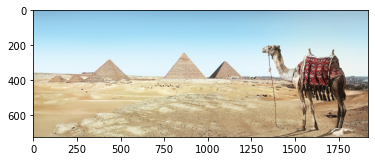

In [18]:
plt.imshow(rgb_image);

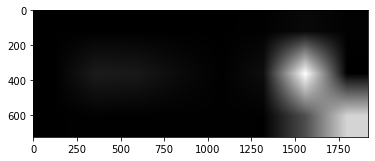

In [19]:
plt.imshow(score_map);

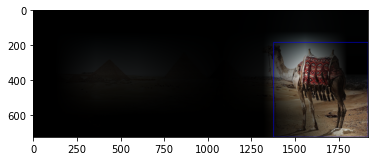

In [20]:
plt.imshow(masked_image);